In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [6]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import layers
from tensorflow.compat.v1.keras.layers import Lambda, Input, Dense ,Input, Flatten, Multiply, Reshape, concatenate
from tensorflow.compat.v1.keras.losses import mse, binary_crossentropy
from tensorflow.compat.v1.keras.utils import plot_model
from  tensorflow.compat.v1.keras.initializers import glorot_uniform  # Or your initializer of choice
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Activation, Dropout,Conv1D, MaxPooling1D, Conv2DTranspose, BatchNormalization


In [7]:
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import seaborn as sn
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import os
import umap
import pandas as pd
from scipy import stats

In [8]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [9]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

from factor_analyzer import FactorAnalyzer, Rotator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [10]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [11]:
# Define computing resource
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
tf.Session(config=config)

In [12]:
def sampling(m_v):

    z_mean, z_log_var = m_v #(mean and var)
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]

    epsilon = K.random_normal(shape=(batch, dim))
    sample = z_mean + K.exp(0.5 * z_log_var) * epsilon
    return sample

In [13]:
def masking(mask_data):
    inputs, outputs_unmasked =mask_data
    mask = tf.math.logical_not(tf.math.equal(inputs, 0))
    mask = tf.cast(mask, dtype=outputs_unmasked.dtype) #convert it to the same data type as the outputs_unmasked
    outputs_masked= outputs_unmasked*mask
    return outputs_masked
    

In [14]:
def vae_loss(true, pred):
    #Calculate the loss function. It's composed of two parts. The first part calculate the MSE, the second part the 
    #KL divergence between the prior and the estimated distribution on the latent factor.

            
    reconstruction_loss = mse(K.flatten(true), K.flatten(pred)) *50

    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = 0.5 * reconstruction_loss + beta * 0.5 * kl_loss
    return vae_loss

In [15]:
os.getcwd()

'/Users/jianqiuzhang/Documents/Psychology/duckworth-grit-scale-data'

In [16]:
# load data
data_read = pd.read_table('/Users/jianqiuzhang/Documents/Psychology/BIG5/data.csv')

col_name = list(data_read.columns)
data = data_read.iloc[:,col_name.index('E1'):col_name.index('O10')+1]

exp_data = data.values

#Get the index of missing values which are set to zero in the original dataset
zeroindex=(exp_data==0)

scaler = StandardScaler()
scaled_exp_data_df=data.copy()
#Normalize the input data to standard Gaussian.
scaled_exp_data_df=pd.DataFrame(scaler.fit_transform(scaled_exp_data_df), columns=data.columns)
scaled_exp_data=scaled_exp_data_df.values
#Set the missing values to zero
scaled_exp_data[zeroindex]=0

#Split the dataset to a training and testing dataset
scaled_X_train, scaled_X_test  =  train_test_split(scaled_exp_data, test_size=0.2, random_state=42)


In [17]:
scaled_exp_data.shape

(19719, 50)

In [18]:
col_names = col_name[col_name.index('E1'):col_name.index('O10')+1]
#Verify that we have gotten the correct columns
print(col_names)

['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9', 'O10']


In [19]:
code_book_raw = pd.read_table('/Users/jianqiuzhang/Documents/Psychology/duckworth-grit-scale-data/codebookItemsBig5.txt',delimiter=',\t')
code_book_raw.columns=list(['Code','Content'])
codes=list(code_book_raw['Code'])
content=list(code_book_raw['Content'])
code_book=pd.DataFrame(data=content,index=codes)
code_book.columns=list(['Content'])
#Import the code book and form a data frame that contains all the codebook items
print(code_book)


                                               Content
E1                         I am the life of the party.
E2                                 I don't talk a lot.
E3                   I feel comfortable around people.
E4                           I keep in the background.
E5                              I start conversations.
E6                               I have little to say.
E7     I talk to a lot of different people at parties.
E8           I don't like to draw attention to myself.
E9         I don't mind being the center of attention.
E10                       I am quiet around strangers.
N1                          I get stressed out easily.
N2                      I am relaxed most of the time.
N3                               I worry about things.
N4                                 I seldom feel blue.
N5                              I am easily disturbed.
N6                                 I get upset easily.
N7                             I change my mood a lot.
N8        

/Users/jianqiuzhang/opt/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [20]:
## hyper params
#Latent_dim: specifies the number of bottleneck layer nodes. 
#hidden_nodes: the number of middle hidden layer nodes
latent_dim =8
hidden_nodes=100


In [21]:
## VAE model
# build VAE encoder from the input layer
inputs = Input(shape=(50,), name='encoder_input')
#The middle hiddenlayer
block1 = Dense(hidden_nodes, kernel_initializer='he_normal', activation='relu')(inputs)
block1 = BatchNormalization(axis=-1)(block1)
flatten = Flatten()(block1)
# the bottleneck layer 
z_mean = Dense(latent_dim, name='z_mean')(flatten)
z_log_var = Dense(latent_dim, name='z_log_var')(flatten)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [22]:
# Take samples from the bottleneck layer distribution and use it as the input to the encoder
x = [z_mean, z_log_var]
z = Lambda(sampling, name='z_sample')(x)

# instantiate encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [23]:
# build decoder, taking the samples from the bottleneck layer as the input
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
#The middle hidden layer. Using Relu as the activation function
de_block1 = Dense(hidden_nodes, activation='relu')(latent_inputs)
de_block1 = BatchNormalization()(de_block1)
#The out put layer without masking out the missing values
outputs_unmasked = Dense(50, activation='linear')(de_block1)



In [24]:
#Masking out missing values so that they don't affect the calculation of the loss function
embedding = layers.Embedding(input_dim=50, output_dim=50, mask_zero=True)
masked_output = embedding(inputs)
#print(masked_output._keras_mask)
masking_layer = layers.Masking()
outputs = masking_layer(outputs_unmasked)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [25]:
# instantiate decoder
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [26]:
# show summary
plot_model(vae, to_file='beta-vae.png', show_shapes=True)
encoder.summary()
decoder.summary()
vae.summary()

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          5100        encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         dense[0][0]                      
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           batch_normalization[0][0]        
______

In [27]:
## hyper params
batch_size = 64
epochs =200
lr = 0.0003
decay = 1e-6
beta = 1


In [28]:
# Compiling
adam = Adam(lr = lr, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=decay, amsgrad=True)
vae.compile(optimizer= adam, loss = vae_loss, metrics=['acc'])

In [29]:
#Initiallize weights
initial_weights = vae.get_weights()

backend_name = K.backend()
if backend_name == 'tensorflow': 
    k_eval = lambda placeholder: placeholder.eval(session=K.get_session())
elif backend_name == 'theano': 
    k_eval = lambda placeholder: placeholder.eval()
else: 
    raise ValueError("Unsupported backend")

new_weights = [k_eval(glorot_uniform()(w.shape)) for w in initial_weights]

vae.set_weights(new_weights)
#Training of the VAE Model
hist = vae.fit(scaled_X_train, scaled_X_train, epochs=epochs, batch_size=batch_size, validation_split=0.15, verbose=2)


Train on 13408 samples, validate on 2367 samples
Epoch 1/200
13408/13408 - 4s - loss: 25.4459 - acc: 0.0292 - val_loss: nan - val_acc: 0.0494
Epoch 2/200
13408/13408 - 2s - loss: 23.8269 - acc: 0.0436 - val_loss: 21.8161 - val_acc: 0.0549
Epoch 3/200
13408/13408 - 2s - loss: 20.2598 - acc: 0.0709 - val_loss: 19.0164 - val_acc: 0.0862
Epoch 4/200
13408/13408 - 2s - loss: 18.5386 - acc: 0.0885 - val_loss: 18.3936 - val_acc: 0.0883
Epoch 5/200
13408/13408 - 2s - loss: 18.1737 - acc: 0.0932 - val_loss: 18.0962 - val_acc: 0.1014
Epoch 6/200
13408/13408 - 2s - loss: 17.9969 - acc: 0.0964 - val_loss: 17.9633 - val_acc: 0.0993
Epoch 7/200
13408/13408 - 2s - loss: 17.8791 - acc: 0.1028 - val_loss: 17.8898 - val_acc: 0.1027
Epoch 8/200
13408/13408 - 2s - loss: 17.7981 - acc: 0.0999 - val_loss: 17.8438 - val_acc: 0.1098
Epoch 9/200
13408/13408 - 2s - loss: 17.7437 - acc: 0.1118 - val_loss: 17.7515 - val_acc: 0.1107
Epoch 10/200
13408/13408 - 2s - loss: 17.7029 - acc: 0.1138 - val_loss: 17.6837 - 

Epoch 85/200
13408/13408 - 2s - loss: 16.9304 - acc: 0.1950 - val_loss: 16.9900 - val_acc: 0.1918
Epoch 86/200
13408/13408 - 2s - loss: 16.9358 - acc: 0.1964 - val_loss: 16.9927 - val_acc: 0.1948
Epoch 87/200
13408/13408 - 2s - loss: 16.9449 - acc: 0.1932 - val_loss: 17.0069 - val_acc: 0.1829
Epoch 88/200
13408/13408 - 2s - loss: 16.9190 - acc: 0.1878 - val_loss: 17.0454 - val_acc: 0.1977
Epoch 89/200
13408/13408 - 2s - loss: 16.9407 - acc: 0.1946 - val_loss: 16.9854 - val_acc: 0.1981
Epoch 90/200
13408/13408 - 2s - loss: 16.9314 - acc: 0.1891 - val_loss: 16.9896 - val_acc: 0.1939
Epoch 91/200
13408/13408 - 2s - loss: 16.9312 - acc: 0.1930 - val_loss: 17.0204 - val_acc: 0.1960
Epoch 92/200
13408/13408 - 2s - loss: 16.9450 - acc: 0.1872 - val_loss: 16.9682 - val_acc: 0.1973
Epoch 93/200
13408/13408 - 202s - loss: 16.9229 - acc: 0.1987 - val_loss: 17.0026 - val_acc: 0.1914
Epoch 94/200
13408/13408 - 3s - loss: 16.9153 - acc: 0.1938 - val_loss: 16.9775 - val_acc: 0.2062
Epoch 95/200
13408

Epoch 168/200
13408/13408 - 2s - loss: 16.8539 - acc: 0.2029 - val_loss: 16.9494 - val_acc: 0.2007
Epoch 169/200
13408/13408 - 2s - loss: 16.8606 - acc: 0.1995 - val_loss: 16.9082 - val_acc: 0.1990
Epoch 170/200
13408/13408 - 2s - loss: 16.8550 - acc: 0.2013 - val_loss: 16.9181 - val_acc: 0.2079
Epoch 171/200
13408/13408 - 2s - loss: 16.8494 - acc: 0.2050 - val_loss: 16.8704 - val_acc: 0.2134
Epoch 172/200
13408/13408 - 2s - loss: 16.8775 - acc: 0.2018 - val_loss: 16.9444 - val_acc: 0.2121
Epoch 173/200
13408/13408 - 2s - loss: 16.8577 - acc: 0.1944 - val_loss: 16.9028 - val_acc: 0.2104
Epoch 174/200
13408/13408 - 2s - loss: 16.8610 - acc: 0.2017 - val_loss: 16.9242 - val_acc: 0.2007
Epoch 175/200
13408/13408 - 2s - loss: 16.8371 - acc: 0.1997 - val_loss: 16.9439 - val_acc: 0.2028
Epoch 176/200
13408/13408 - 2s - loss: 16.8764 - acc: 0.1996 - val_loss: 16.9690 - val_acc: 0.2100
Epoch 177/200
13408/13408 - 2s - loss: 16.8655 - acc: 0.1994 - val_loss: 16.9129 - val_acc: 0.2172
Epoch 178/

(16.653831680225014, 26.20955234427441)

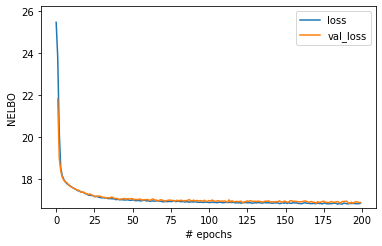

In [30]:
#Code module for printing out the loss function of the training process
# curve NELBO
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))
fig, ax = plt.subplots(figsize=golden_size(6))
hist_vae = {k:hist.history[k] for k in ('loss', 'val_loss')}
hist_vae_df = pd.DataFrame(hist_vae)
hist_vae_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99 * hist_vae_df[1:].values.min(),
            1.1 * hist_vae_df[1:].values.max())

NameError: name 'node' is not defined

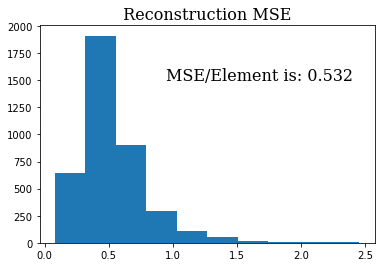

In [31]:

# Calculate the MSE between the input and the reconstructed input scores
#First, we use the encoder model and predict the latent factors. We take the samples from the bottleneck layer
latent_pred = encoder.predict(scaled_X_test)[2]
#We then use the decoder or the generative model to predict the reconstructed input item
recon= decoder.predict(latent_pred)
#We get the squared errors between the input and the reconstructed scores.
recon_loss_1 = ((scaled_X_test - recon) ** 2).mean(axis=1)
#We inspect the histogram and various statistics
plt.hist(recon_loss_1)
plt.title(' Reconstruction MSE ', fontdict=font)
recon_loss = ((scaled_X_test - recon) ** 2).mean(axis=None)
format_float = "{:.3f}".format(recon_loss)
print_text='MSE/Element is: '+str(format_float)
xpos=1
ytop=1500
ystep=250
plt.text(xpos-0.05, ytop, print_text, fontdict=font)
plt.text(xpos, ytop-ystep*2, node + ' Middle Layer Nodes', fontdict=font)
plt.xlabel('Mean Square Error/Sample', fontdict=font)
plt.ylabel('Frequency', fontdict=font)
print('MSE is:', recon_loss)

plt.show()
#plt.savefig('Big5MSEHist1ReluGreat1.png')

In [32]:
loss,_  = vae.evaluate(scaled_X_test, scaled_X_test, batch_size=64, verbose=0)

print('Test loss vae:', loss)


Test loss vae: 16.793347418670965


In [76]:
filename='Big8Layers1Encoder100ReluData2Copy1'

In [33]:
#Same the generated models from VAE training
decoder.save('Big8Layers1Decoder100ReluData2Copy1.h5')
encoder.save('Big8Layers1Encoder100ReluData2Copy1.h5')


In [34]:
#Here we get the factor lodings
#First we get a prediction of the latent factors zmean
latent_pred_sample = encoder.predict(scaled_exp_data)[0]
#Then we use this zmean to predict the reconstructed input scores. Note that samples are used in training only.
out=decoder.predict(latent_pred_sample)
#Construct DataFrame objects for both the input and the output 
indata=pd.DataFrame(data=scaled_exp_data, columns=col_names)
inout=pd.DataFrame(data=out, columns=col_names)
#Constructing the Factor column names
factors=[]
for i in range(latent_dim):
    factors.append('F'+str(i))
factor_names=list(factors)    
for i in range(latent_dim):
    inout.insert(i,factor_names[i],latent_pred_sample[:,i],True)
#Show the Data
inout

,F0,F1,F2,F3,F4,F5,F6,F7,E1,E2,...,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10
0,0.206250,0.398801,-0.079614,0.125715,-0.479329,0.735730,0.264279,2.617698,0.674667,-0.861673,...,0.476063,-0.740136,0.301326,-0.491399,0.898961,-0.769377,0.827226,-0.151587,0.044670,0.861420
1,0.817045,0.706441,0.991680,0.170176,0.230763,1.740441,0.574143,-0.532866,-0.679106,0.517827,...,-1.174016,0.809955,-1.359245,0.757075,-1.481933,1.073856,-1.035050,-0.983634,-0.684513,-1.726894
2,-0.543446,-3.326695,1.660012,-0.237013,-0.493636,0.125142,0.052446,-0.161468,0.814948,-0.532746,...,0.709367,0.405841,0.755993,0.097255,1.090872,-0.504367,0.810468,0.773067,0.945505,0.859634
3,-1.412038,-0.865372,-0.432485,0.843960,0.060715,-0.804785,0.166568,-1.372482,-0.377504,0.675248,...,-0.048930,0.451612,0.806310,0.172856,0.332260,-0.528706,-0.243147,0.208203,0.561147,0.617381
4,-0.196862,0.221364,0.323918,-1.729369,1.425266,0.225897,0.931979,0.204044,-0.033723,-0.297715,...,-0.955300,-0.032093,-0.428775,-0.156739,-0.491834,-0.105074,-0.148512,-1.131451,-0.613397,-0.566963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19714,-1.584326,-0.891866,0.315436,-0.279921,1.401899,0.726318,1.168909,-0.760891,-0.381432,0.676255,...,-1.476273,0.944863,0.400544,0.456460,-0.053919,-0.357104,-0.420097,-1.358152,0.380558,-0.105348
19715,-0.032038,1.839270,-0.028914,-0.229511,0.020443,0.811266,0.042012,-0.085191,-0.433733,0.509673,...,-0.782295,0.432032,-1.006009,0.459426,-0.854226,0.588081,-0.447431,-0.743295,-0.988676,-1.084442
19716,-0.202201,-0.276607,0.642460,0.658610,-0.429100,-1.213744,-0.963946,-2.035944,-0.517037,0.342015,...,0.283978,1.058819,0.287058,0.874882,-0.135686,0.307458,-0.364405,0.579254,0.305749,0.030224
19717,-0.499260,-1.467247,-0.123634,0.094981,-0.487730,0.944872,0.297754,-0.581385,-0.485014,0.724512,...,0.322286,0.021428,0.580717,0.028895,0.463937,-0.469377,0.275976,0.310863,0.401456,0.418741


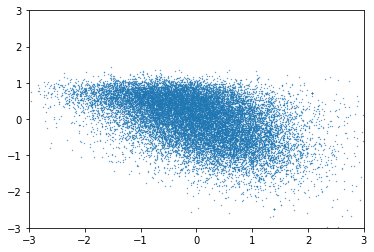

0.7373858173722698
0.755321157211312
0.7884941666121617
0.7793843078432725
0.7982925087425417
0.7488049414046407
0.7875373697899736
0.6663508722972662
0.7025969294955071
0.7484126664028138
0.7581204220791093
0.7131712949160237
0.7576372226436099
0.641957210334221
0.6423896214558495
0.7879121817525445
0.7840854444541393
0.8175719193851234
0.7664499791297503
0.7559958922959046
0.7180388968013697
0.7369737588413778
0.7297871270112299
0.8193258677224856
0.7477195041990311
0.7425414296986595
0.7938992018735557
0.6697801371774569
0.7818912974161442
0.6763576054179633
0.6880061167658085
0.7269151590352544
0.6284941583004297
0.7397264969107403
0.722585100199131
0.7514908618893001
0.7022861193711257
0.6408356129970959
0.7087883562418369
0.6520453730211349
0.7784946341886266
0.7828838039234881
0.7984112436900836
0.7262042695482824
0.739061999357196
0.8433876237873191
0.7383237337322598
0.77678988278895
0.6130821537645051
0.7788041715574685


In [71]:
#Inspecting the relationship between input factors and the reconstructed items.
col='O1'
fac=2;
plt.scatter(inout.iloc[:,fac],inout[col],s=0.1);
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

#Inspecting the correlation between input data and their reconstructed ones
corr_array=[]
for coln in col_names:
    corr_num=inout[coln].corr(indata[coln]) 
    corr_array.append(corr_num)
    print(corr_num)
#inout.iloc[:,fac].corr(inout[col])

In [39]:
#Calculate the mean and standard deviations of the correlations
import statistics as stat
meancorr=sum(corr_array)/len(corr_array)
print(meancorr)
stdcorr=stat.stdev(corr_array)
print(stdcorr)

0.7369978617452978
0.05760753918848441


In [73]:
#Calculate factor loadings
latent_dim=len(latent_pred_sample[0])
ffCorr=inout.corr()
facLoad=ffCorr.iloc[latent_dim:50+latent_dim,0:latent_dim]
idx=list(facLoad.index)
col=list(facLoad.columns)
#get an rotator and get the rotated factor loadings
rotator = Rotator()
facLoadRotate=rotator.fit_transform(facLoad)
#Store the rotated factor loadings in a DataFrame object
factor_loadings=pd.DataFrame(facLoadRotate,index=idx,columns=col)
factor_loadings

,F0,F1,F2,F3,F4,F5,F6,F7
E1,-0.185865,0.083703,0.000982,0.081134,0.143072,0.030193,0.123268,0.962359
E2,-0.133198,-0.017880,0.060547,-0.036949,-0.232375,0.012658,0.024558,-0.979968
E3,-0.097470,0.350029,0.029658,0.051613,0.364475,0.174352,0.010083,0.845608
E4,-0.110820,-0.209299,0.052651,0.068495,-0.111631,-0.046981,0.046053,-0.964804
E5,-0.037794,0.121006,-0.070591,0.059895,0.322978,0.135244,0.054879,0.938860
E6,-0.252722,-0.141834,0.286443,0.007919,-0.247357,-0.072162,-0.072079,-0.867014
E7,-0.062783,0.157907,-0.025808,0.064809,0.255449,0.075138,0.056677,0.956369
E8,0.043119,-0.035081,0.009261,0.121145,0.038179,0.088037,-0.081674,-0.974281
E9,-0.173188,0.065771,-0.099155,0.015543,0.024918,-0.012979,0.150336,0.960880
E10,-0.068611,-0.255266,0.024080,0.105518,-0.118926,-0.056301,0.013074,-0.942234


          0         1         2         3         4         5         6  \
0  1.000000  0.008935 -0.048319 -0.042065  0.013689  0.003320 -0.058252   
1  0.008935  1.000000 -0.019301 -0.042251 -0.043871  0.049843 -0.030472   
2 -0.048319 -0.019301  1.000000 -0.029718 -0.014841  0.008302 -0.116330   
3 -0.042065 -0.042251 -0.029718  1.000000  0.017612 -0.009283 -0.046000   
4  0.013689 -0.043871 -0.014841  0.017612  1.000000  0.044690  0.045285   
5  0.003320  0.049843  0.008302 -0.009283  0.044690  1.000000 -0.017031   
6 -0.058252 -0.030472 -0.116330 -0.046000  0.045285 -0.017031  1.000000   
7 -0.004315  0.019739 -0.007141  0.017526  0.093362 -0.007811  0.018263   

          7  
0 -0.004315  
1  0.019739  
2 -0.007141  
3  0.017526  
4  0.093362  
5 -0.007811  
6  0.018263  
7  1.000000  


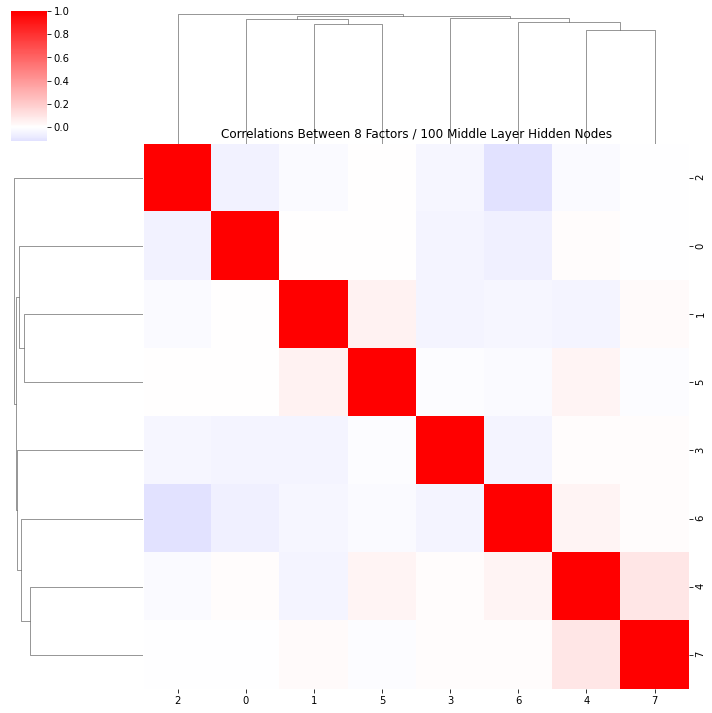

In [74]:
#Find the predicted values of the latent bottleneck layer nodes based on all input data 
# take zmean as the predicted value
#Rotate the predicted latent factors by the rotation matrix obtained by varimax rotation on factor loadings
latent_pred = encoder.predict(scaled_exp_data)[0] @ rotator.rotation_ 
#Create a DataFrame object for calculating the correlaitons
corr_df = pd.DataFrame(data=latent_pred)
#Find the correlations between the latent factors
corr = corr_df.corr()
#Plot a cluster map and inspect the correlations between the latent factors.
cluster_plot=sn.clustermap(corr, cmap='bwr', center=0)
node=str(hidden_nodes)
cluster_plot.ax_heatmap.set_title('Correlations Between '+str(latent_dim)+' Factors / '+ node+' Middle Layer Hidden Nodes')
print(corr)
corr=corr.round(2)
#Save the correlations to a file
corr.to_csv('Big8corrOfRotatedFactors2.csv', index=True, header=True)

In [ ]:
#Save factor loadings to a file for congruence score study after 10 runs
cvsfilename=filename+'-FactorLoadings.csv'
factor_loadings.to_csv(cvsfilename, index=True, header=True)

In [77]:
#In this block of code, we get items with top loadings on each of the latent factors
factor_columns=list(factor_loadings.columns)
factor_loadings_abs=factor_loadings.abs()
sortAllF=pd.DataFrame(columns=factor_columns)
#for each latent factor
for i in range(latent_dim):
   #First get the factor loadings of all items on the current factor 
   current_factor=factor_loadings.iloc[0:50,i]
   #Get the absolute value 
   current_factor_abs=current_factor.abs()
   #Sort factor loading values in descending order, such that items with higher loadings are listed first
   current_factor_abs.sort_values(axis = 0, ascending = False, inplace = True, na_position ='last')    
   # Cut out items with factor loading less than 0.2
   idx=current_factor_abs[current_factor_abs>0.2].index 
   sorted_currentFactor=current_factor.loc[idx]
   #Get factor loadings on all factors for the selected items 
   current_sortAllF=factor_loadings.loc[idx] 
   if(len(sorted_currentFactor)>0):
      first=sorted_currentFactor.iloc[0]
      #We want to switch the sign of the factor loadings according to the item with the highest absolute loading value  
      if(sorted_currentFactor.iloc[0]<0):
         current_sortAllF *=(-1)
        
      length_cf=sorted_currentFactor.size
      #If we have more than 15 items with loaddings >0.2, we only keep items with loadings 
      #that's the highest with the current factor
      if(length_cf>15):
         current_sortAllF_abs=current_sortAllF.abs()
         max_index = current_sortAllF_abs.idxmax(axis=1)
         keep_idx = max_index[max_index == factor_columns[i]].index
         #We want to print out at least 10 items for each factor
         if(keep_idx.size > 10):    
            current_sortAllF=current_sortAllF.loc[keep_idx]
         else :
            current_sortAllF =current_sortAllF.iloc[0:10]
      #We save the rounded loadings of items that ranked at least within top 10 for a factor to current_sortAllF
      current_sortAllF=current_sortAllF.round(2)
      #We also want to insert the content of these items in to the array  
      code_content=code_book.loc[current_sortAllF.index]  
      current_sortAllF.insert(0,'content',code_content.iloc[:,0],True)
      #For the current factor, print the items with the highest loading and it's content
      print(current_sortAllF)   
      #Save the table to a larger table that contains the top loading items of all factors
      sortAllF=sortAllF.append(current_sortAllF)
      #sortAllF=sortAllF.append(pd.DataFrame(data=factor_columns))
      sortAllF=sortAllF.append(pd.DataFrame(range(1)))
#Save the output to a file
CurrentFilename=filename+'-FinalFactorLoadingsRotatedUnsorted'+'.csv'
sortAllF.to_csv(CurrentFilename, index=True, header=True)

                                               content    F0    F1    F2  \
A1                   I feel little concern for others.  0.55  0.13 -0.21   
N4                                 I seldom feel blue.  0.46 -0.66 -0.08   
A10                        I make people feel at ease.  0.32 -0.21  0.07   
N2                      I am relaxed most of the time.  0.32 -0.85  0.01   
O7                    I am quick to understand things.  0.30 -0.25  0.78   
O5                             I have excellent ideas.  0.30 -0.12  0.64   
O4              I am not interested in abstract ideas.  0.30  0.16 -0.71   
A7               I am not really interested in others.  0.27  0.15 -0.04   
C10                          I am exacting in my work.  0.26 -0.06  0.39   
E6                               I have little to say.  0.25  0.14 -0.29   
A5     I am not interested in other people's problems.  0.25  0.01 -0.03   
A6                                I have a soft heart.  0.23  0.23 -0.13   
C6   I often